# Predicting Global Conflict with LSTM Modeling| Mason Casebeer Notebook Walkthrough

In this project, we will be using the University of Uppsallas' dyadic conflict and conflict termination datasets to create an LSTM model which will try to predict trends in global conflicts in a region

## 1.0 Imports and loading datasets

In [211]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from IPython.display import Markdown, display

dyadic = pd.read_csv('Dyadic_v25_1.csv')
aid = pd.read_csv('micFINAL.csv')
term = pd.read_csv('UCDPConflictTerminationDataset_v4_2024_Dyad.csv')

### 1.1 Loading dyadic dataset

in this cell we load in the dyadic dataset. we then merge conflicts on a year-region basis so we 
can aggregate conflict information across the 5 regions of the dataset

In [ ]:
# Aggregate dyadic events to a region-year dataset (1970-2023)
# We compute: ongoing unique conflicts, unique dyads, total events, avg/max intensity,
# intensity-level counts, and counts by `type_of_conflict`. Save as `region_yearly` and CSV.
dyadic['region_single'] = dyadic['region'].apply(lambda x: x.split(',')[0])

# choose region column if available (fall back to 'region')
region_col = 'region_single' if 'region_single' in dyadic.columns else 'region'

# Ensure 'year' and intensity are numeric
dyadic['year'] = dyadic['year'].astype(int)
dyadic['intensity_level'] = pd.to_numeric(dyadic['intensity_level'], errors='coerce')

# Basic per-region-year aggregates
agg = dyadic.groupby([region_col, 'year']).agg(
    ongoing_conflicts=('conflict_id', 'nunique'),
    unique_dyads=('dyad_id', 'nunique'),
    total_events=('dyad_id', 'count'),
    avg_intensity=('intensity_level', 'mean'),
    max_intensity=('intensity_level', 'max'),
    incompatibility_mode=('incompatibility', lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan),
).reset_index()

# intensity-level breakdown (creates intensity_1, intensity_2, ...)
intensity_ct = pd.crosstab([dyadic[region_col], dyadic['year']], dyadic['intensity_level']).rename(columns=lambda c: f'intensity_{int(c)}' if not pd.isna(c) else 'intensity_na').reset_index()

# type_of_conflict breakdown (many possible types; create prefixed columns)
type_ct = pd.crosstab([dyadic[region_col], dyadic['year']], dyadic['type_of_conflict']).add_prefix('type_').reset_index()

# Merge aggregates and pivot tables
region_yearly = agg.merge(intensity_ct, left_on=[region_col, 'year'], right_on=[region_col, 'year'], how='left')
region_yearly = region_yearly.merge(type_ct, left_on=[region_col, 'year'], right_on=[region_col, 'year'], how='left')

# Build full grid of regions × years 1970-2023 to ensure coverage
regions = dyadic[region_col].dropna().unique().tolist()
years = list(range(1970, 2024))
full_index = pd.MultiIndex.from_product([regions, years], names=[region_col, 'year'])
region_yearly = region_yearly.set_index([region_col, 'year']).reindex(full_index).reset_index()

# Fill missing numeric values with 0 and keep object columns as-is (or fill with '' where appropriate)
num_cols = region_yearly.select_dtypes(include=['number']).columns.tolist()
region_yearly[num_cols] = region_yearly[num_cols].fillna(0)
obj_cols = [c for c in region_yearly.columns if c not in num_cols and c not in [region_col]]
region_yearly[obj_cols] = region_yearly[obj_cols].fillna('')

# Ensure integer columns where sensible
for c in ['ongoing_conflicts','unique_dyads','total_events']:
    if c in region_yearly.columns:
        region_yearly[c] = region_yearly[c].astype(int)

#Let's take a quick look! (uncollapse output if you want to see)
region_yearly.head(2)

,region_single,year,ongoing_conflicts,unique_dyads,total_events,avg_intensity,max_intensity,incompatibility_mode,intensity_1,intensity_2,type_1,type_2,type_3,type_4
0,4,1970,8,9,9,1.222222,2.0,1.0,7.0,2.0,4.0,0.0,4.0,1.0
1,4,1971,11,13,13,1.076923,2.0,1.0,12.0,1.0,4.0,0.0,7.0,2.0


### 1.2 Loading termination dataset

In [ ]:
# pick the same region column as used earlier
region_col = 'region_single' if 'region_single' in dyadic.columns else 'region'

# Ensure 'year' is numeric on the termination dataset
term['year'] = term['year'].astype(int)

# If term doesn't have region info, map conflict -> region from `dyadic`
if region_col not in term.columns:
    if region_col in dyadic.columns:
        mapping = dyadic.drop_duplicates(['conflict_id', region_col]).set_index('conflict_id')[region_col].to_dict()
        term[region_col] = term['conflict_id'].map(mapping)
    else:
        term[region_col] = ''

# Basic aggregates: number of terminated dyads and total termination events
term_agg = term.groupby([region_col, 'year']).agg(
    terminated_dyads=('dyad_id', 'nunique'),
    term_events=('dyad_id', 'count'),
    mode_outcome=('d_outcome', lambda x: x.mode().iloc[0] if not x.mode().empty else ''),
).reset_index()

# Outcome-type breakdown (prefixed with 'term_outcome_')
outcome_ct = pd.crosstab([term[region_col], term['year']], term['d_outcome']).add_prefix('term_outcome_').reset_index()

# Merge term aggregates and outcomes
term_yearly = term_agg.merge(outcome_ct, on=[region_col, 'year'], how='left')

# Merge into region_yearly (created earlier). If not present, create placeholder and then merge
try:
    region_yearly
except NameError:
    # create an empty region_yearly structure with regions × years grid if missing
    regions = dyadic[region_col].dropna().unique().tolist() if region_col in dyadic.columns else []
    years = list(range(1970, 2024))
    full_index = pd.MultiIndex.from_product([regions, years], names=[region_col, 'year'])
    region_yearly = pd.DataFrame(index=full_index).reset_index()

# merge term features into region_yearly
region_yearly = region_yearly.merge(term_yearly, on=[region_col, 'year'], how='left')

# Fill missing numeric termination columns with 0 and strings with ''
term_num_cols = [c for c in region_yearly.columns if c in ['terminated_dyads','term_events'] or c.startswith('term_outcome_')]
for c in term_num_cols:
    if c in region_yearly.columns:
        region_yearly[c] = region_yearly[c].fillna(0).astype(int)

if 'mode_outcome' in region_yearly.columns:
    region_yearly['mode_outcome'] = region_yearly['mode_outcome'].fillna('')

# Save updated region_yearly
region_yearly.to_csv('region_yearly_1970_2023.csv', index=False)

# Show merged head
region_yearly['region_single'] = pd.to_numeric(region_yearly['region_single'])
region_yearly.dtypes
region_yearly.head(2)

,region_single,year,ongoing_conflicts,unique_dyads,total_events,avg_intensity,max_intensity,incompatibility_mode,intensity_1,intensity_2,...,type_4,terminated_dyads,term_events,mode_outcome,term_outcome_1.0,term_outcome_2.0,term_outcome_3.0,term_outcome_4.0,term_outcome_5.0,term_outcome_6.0
0,4,1970,8,9,9,1.222222,2.0,1.0,7.0,2.0,...,1.0,9,9,3.0,0,0,1,0,1,0
1,4,1971,11,13,13,1.076923,2.0,1.0,12.0,1.0,...,2.0,13,13,3.0,0,0,3,1,1,0


## 2.0 Data Exploration

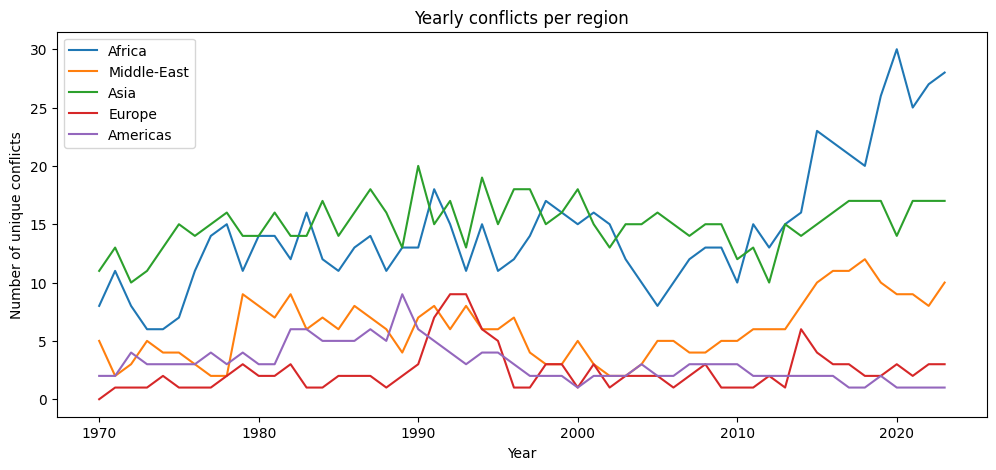

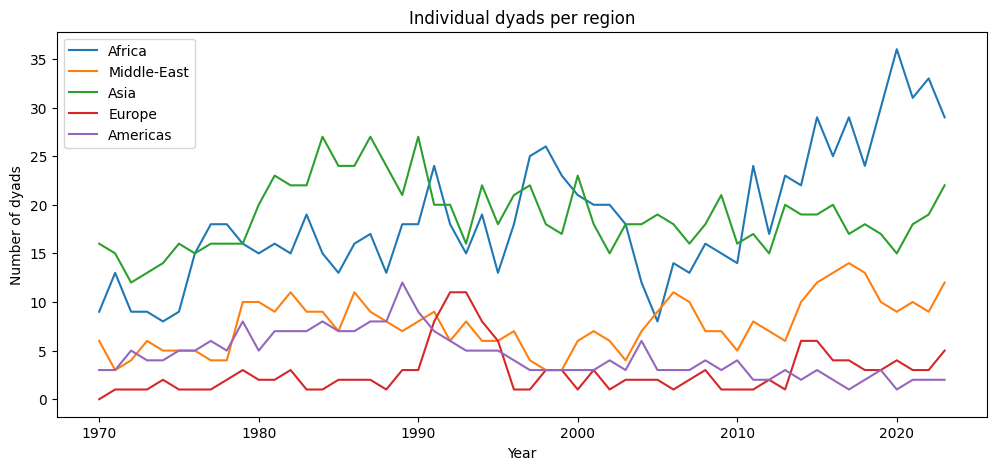

In [214]:
plt.figure(figsize=(12, 5))
region_lookup = {1:'Europe',2:'Middle-East',3:'Asia',4:'Africa',5:'Americas'}
regions= region_yearly['region_single'].unique()

for region in regions:
    region_data = region_yearly[region_yearly['region_single'] == region]
    plt.plot(region_data['year'],region_data['ongoing_conflicts'],label=region_lookup.get(int(region)))

plt.ylabel('Number of unique conflicts')
plt.xlabel('Year')
plt.title('Yearly conflicts per region')
plt.legend()
plt.show()

region_lookup = {1:'Europe',2:'Middle-East',3:'Asia',4:'Africa',5:'Americas'}
regions= region_yearly['region_single'].unique()

plt.figure(figsize=(12, 5))
for region in regions:
    region_data = region_yearly[region_yearly['region_single'] == region]
    plt.plot(region_data['year'],region_data['unique_dyads'],label=region_lookup.get(int(region)))

plt.ylabel('Number of dyads')
plt.xlabel('Year')
plt.title('Individual dyads per region')
plt.legend()
plt.show()

In [215]:
for region in regions:
    region_data = region_yearly[region_yearly['region_single'] == region]
    print(f"Region {region_lookup.get(region)}: average conflict intensity is {region_data['avg_intensity'].mean():.2f}")


Region Africa: average conflict intensity is 1.21
Region Middle-East: average conflict intensity is 1.19
Region Asia: average conflict intensity is 1.19
Region Europe: average conflict intensity is 1.15
Region Americas: average conflict intensity is 1.11


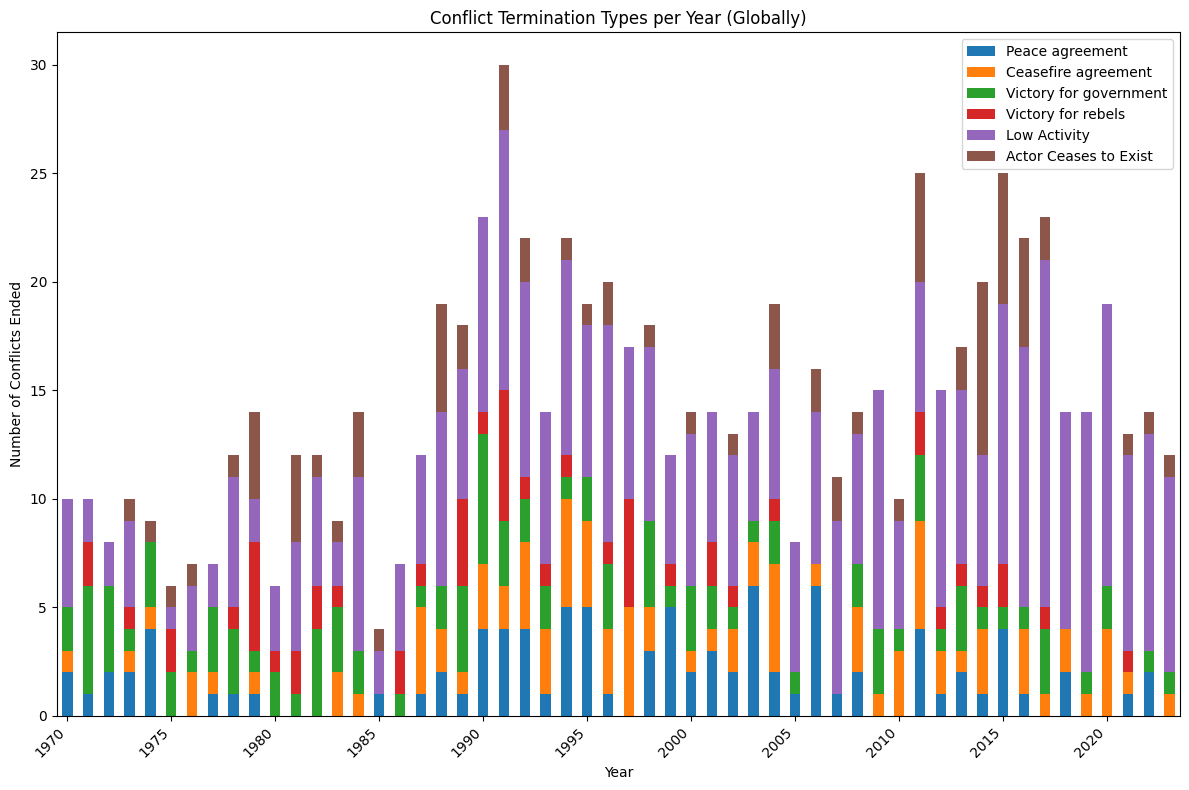

In [216]:
peace_types = ['term_outcome_1.0','term_outcome_2.0','term_outcome_3.0','term_outcome_4.0','term_outcome_5.0','term_outcome_6.0',]
peace_type_lookup = {'term_outcome_1.0':'Peace agreement','term_outcome_2.0':'Ceasefire agreement','term_outcome_3.0':'Victory for government','term_outcome_4.0':'Victory for rebels','term_outcome_5.0':'Low Activity','term_outcome_6.0':'Actor Ceases to Exist',}
region_yearly = region_yearly.sort_values('year')
region_agg = region_yearly.groupby('year')[peace_types].sum().reset_index()
region_agg = region_agg.rename(columns=peace_type_lookup)

plt.figure(figsize=(12, 8))

#from here on out i'm switching to ax based plotting because its better as these plots get more complex

ax = plt.gca()
region_agg.plot(
    x='year',
    y=list(peace_type_lookup.values()),
    kind='bar',
    stacked=True,
    ax=ax
)

ax.set_ylabel("Number of Conflicts Ended")
ax.set_xlabel("Year")
ax.set_title("Conflict Termination Types per Year (Globally)")

#ticks every 5 years
year_positions = range(len(region_agg))           # bar positions 0..N-1
year_labels = region_agg['year'].values           # actual year numbers

# choose every 5th index
indices_to_label = list(range(0, len(region_agg), 5))

ax.set_xticks(indices_to_label)
ax.set_xticklabels(year_labels[indices_to_label], rotation=45, ha='right')


ax.legend()
plt.tight_layout()
plt.show()

## 3.0 Data Preparation

In [217]:
df = region_yearly.copy()

features_cont = [
    # 'region_single',
    'ongoing_conflicts',
    'unique_dyads',
    'total_events',
    'intensity_1',
    'intensity_2',
    'type_1',
    'type_2',
    'type_3',
    'type_4',
]

target = 'term_events'

X_seq, y_labels = [], []
seq_len = 10

for region, group in df.groupby('region_single'):
    X_cont = group[features_cont].values.astype(np.float32)
    y = group[target].values

    for t in range(len(X_cont) - seq_len):
        X_seq.append(X_cont[t : t + seq_len])   # ALWAYS length seq_len
        y_labels.append(y[t + seq_len])



In [218]:
scaler = StandardScaler()
# Clean continuous sequences (replace NaNs with 0 for scaling step)
X_clean = [np.nan_to_num(seq, nan=0.0) for seq in X_seq]
all_steps = np.concatenate(X_clean, axis=0)
scaler.fit(all_steps)
X_scaled = [scaler.transform(seq) for seq in X_clean]

X_tensor = torch.stack([torch.tensor(seq, dtype=torch.float32) for seq in X_scaled])
y_tensor = torch.tensor(y_labels, dtype=torch.float32)
seq_len = 10

In [219]:
# Split continuous, categorical, and labels together
X_train,X_test, y_train, y_test = train_test_split(
    X_tensor, y_tensor, test_size=0.2, random_state=42
)

train_ds = TensorDataset(X_train, y_train)
test_ds  = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=64)


In [220]:
print(X_tensor[0])
print(y_tensor[0])

tensor([[-1.3850, -1.3777, -1.3777, -1.3447, -0.9505, -0.0822, -0.6110, -1.4030,
         -0.6354],
        [-1.2143, -1.2466, -1.2466, -1.1850, -0.9505, -0.0822, -0.6110, -1.2303,
         -0.6354],
        [-1.2143, -1.2466, -1.2466, -1.1850, -0.9505, -0.0822, -0.6110, -1.2303,
         -0.6354],
        [-1.2143, -1.2466, -1.2466, -1.1850, -0.9505, -0.0822, -0.6110, -1.2303,
         -0.6354],
        [-1.0435, -1.1155, -1.1155, -1.1850, -0.4960, -0.0822,  1.1484, -1.2303,
         -0.6354],
        [-1.2143, -1.2466, -1.2466, -1.1850, -0.9505, -0.0822, -0.6110, -1.2303,
         -0.6354],
        [-1.2143, -1.2466, -1.2466, -1.1850, -0.9505, -0.0822, -0.6110, -1.2303,
         -0.6354],
        [-1.2143, -1.2466, -1.2466, -1.1850, -0.9505, -0.0822, -0.6110, -1.2303,
         -0.6354],
        [-1.0435, -1.1155, -1.1155, -1.0253, -0.9505, -0.0822, -0.6110, -1.0576,
         -0.6354],
        [-0.8728, -0.9845, -0.9845, -0.8656, -0.9505, -0.0822,  1.1484, -1.0576,
         -0.6354]])

In [221]:
import torch.nn as nn

class LSTMPoisson(nn.Module):
    def __init__(self, n_cont, hidden_dim=64):
        super().__init__()
        self.lstm = nn.LSTM(n_cont, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, cont_x):
        out, _ = self.lstm(cont_x)
        last = out[:, -1, :]            # take final timestep
        return torch.exp(self.fc(last)).squeeze(-1)  # ensure positive rate



In [223]:
model = LSTMNoEmb(n_cont=len(features_cont), hidden_dim=64)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()


for epoch in range(100):
    model.train()
    for xb, yb in train_loader:
        xb = xb.float()
        yb = yb.float()
        optimizer.zero_grad()
        preds = model(xb).flatten()
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
    print("Epoch", epoch, "loss", float(loss))


Epoch 0 loss 220.45249938964844
Epoch 1 loss 156.0915069580078
Epoch 2 loss 170.29296875
Epoch 3 loss 142.95497131347656
Epoch 4 loss 157.7885284423828
Epoch 5 loss 174.5350799560547
Epoch 6 loss 190.9889678955078
Epoch 7 loss 187.5540313720703
Epoch 8 loss 161.5686798095703
Epoch 9 loss 196.77012634277344
Epoch 10 loss 177.2798309326172
Epoch 11 loss 198.1190643310547
Epoch 12 loss 197.1453857421875
Epoch 13 loss 188.0638885498047
Epoch 14 loss 234.87950134277344
Epoch 15 loss 186.121337890625
Epoch 16 loss 176.1806640625
Epoch 17 loss 162.2123565673828
Epoch 18 loss 160.68548583984375
Epoch 19 loss 131.27853393554688
Epoch 20 loss 151.76614379882812
Epoch 21 loss 177.71160888671875
Epoch 22 loss 208.8006134033203
Epoch 23 loss 201.6885986328125
Epoch 24 loss 195.7281951904297
Epoch 25 loss 177.2108917236328
Epoch 26 loss 173.9954071044922
Epoch 27 loss 175.33526611328125
Epoch 28 loss 195.8467254638672
Epoch 29 loss 207.9960479736328
Epoch 30 loss 160.3123321533203
Epoch 31 loss 159.

## 4.0 LSTM

## 5.0 Results and Conclusion